**STEP 1: Import all Necessary Modules**
---
I started by importing all the modules I would need to read the csv, geocode 
the addresses, conduct a spatial join and attribute join, and finally create a map of my resulting geodataframe. 

In [ ]:
### Import all necesary modules
!pip install geopandas
!sudo apt install python3-rtree
import geopandas as gpd
import pandas as pd
from geopandas.tools import geocode
import matplotlib.pyplot as plt
%matplotlib inline

**STEP 2: Read in the data and geocode the addresses**
---
I started by reading in the csv data as pandas dataframe and then I created a for loop that iterated over the dataframe by row and added the address in proper format to a list of addresses as a string. I then passed that list into the geocode function and used bing and an API key I created myself to geocode them. The result is a geodataframe with the coordinates of each starbucks location. 

In [ ]:
### Read in the Starbucks addresses csv as a pandas dataFrame
data = pd.read_csv('starbucks_address.csv')

### Create a list to pass to the geocode function containing properly formated addresses
adr_list = []
for index, row in data.iterrows():
    adr_list.append(f"{row['Street Address']}, {row['City']}, {row['State/Province']}")

### Geocode the address from adr_list into lat, lon coordinates
starbs_coords = geocode(adr_list,  provider='bing', 
                        api_key="AtAqYa1pmvurx4XjTQJqoB2oVpTN3uOo9QL14w5BdEtxgwobKTNQ8rrFfKO6xdpv")

**STEP 3: Join the GeoDataFrame with the AZ Zipcodes Polygon and get the count**
---
Next I read in the AZ zipcodes shapefile as a geodataframe using geopandas. I then ensured that the starbucks coordinates geodataframe and the AZ zipcodes were in the same projection before I conducted and spatial operations. Once confirmed, I conducted a spatial join to see how many starbiucks locations were in each zipcode retaining the polygon's geometry. Then I created a new dataframe with just the zipcode and the count of starbucks locations in each by using the groupby method. I saved this as a new dataframe and then conducted an attribute merge to the original zipcodes polygon to "clean things up". Finally, I renamed the 'addresses' columns to 'Starbucks' to reflect the data I had just added. 

In [46]:
### Read in the AZ zipcode shapefile as a GeoDataFrame
az_zip = gpd.read_file('AZ_zipcodes.shp')

### Ensure the az_zip and the starbs_coords are in the same projection 
#az_zip.crs = 4269
starbs_coords = starbs_coords.to_crs(epsg='4269')

### Count the number of Starbucks locations within each zip code using sjoin function
az_starbs = gpd.sjoin(az_zip, starbs_coords, how="left", op='contains')

### Get count of starbucks by zipcode using groupby, save as dataframe
az_starbs_count = az_starbs.groupby("Zipcode", as_index=False).count()[["Zipcode","address"]]

### Attribute join dataFrame with count to az_zip file by zipcode, rename column
starbs_by_zip = az_zip.merge(az_starbs_count, on='Zipcode')
starbs_by_zip = starbs_by_zip.rename(columns={'address':'Starbucks'})

**STEP 4: Make a map of Starbucks locations by Zipcode**
---
Finally, using matplotlib.pyplot and the technique shown in the "real world example' in module 5 I created a cloropleth map of showing the polygons of all the zipcodes in AZ, colored from light to dark based on the number of starbucks locations within each zipcode. I did some research to look at the availiable cmaps so I could find one that fit the Starbucks color scheme. Lastly, I exported the map as a png. 

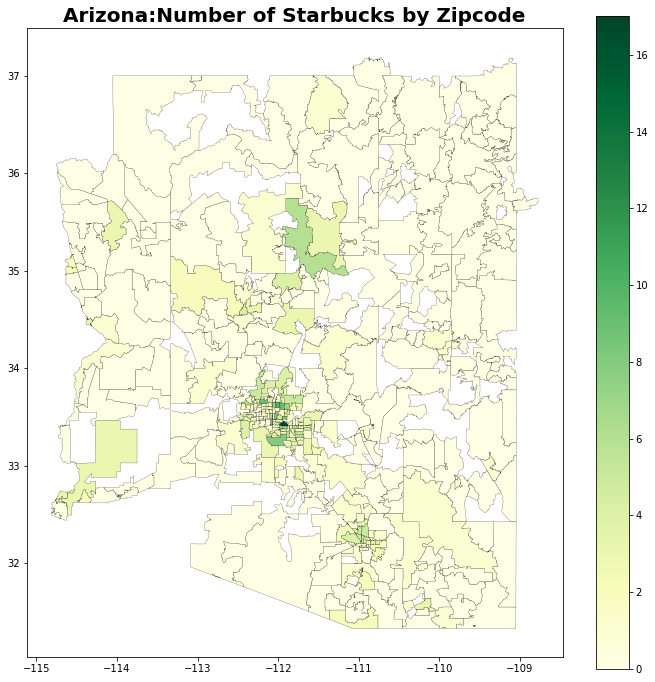

In [57]:
### Create a color map showing the number of starbucks by zipcode and export it
fig, ax = plt.subplots(1, figsize=(12, 12))
starbs_by_zip.plot(column="Starbucks",figsize=(10,10), ax=ax, cmap='YlGn',edgecolor='black', linewidth=0.2)

vmin = starbs_by_zip["Starbucks"].min()
vmax = starbs_by_zip["Starbucks"].max()

plt.title("Arizona:Number of Starbucks by Zipcode",fontdict={'fontsize':20, 'fontweight':'bold'})
    
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax),cmap='YlGn')
sm._A = []
fig.colorbar(sm)

plt.savefig("starbs_by_AZzip.png",dpi=400,bbox_inches='tight')